### Import libraries

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import calendar

### Load cleaned CSVs from data/processed/

In [34]:
categories_df = pd.read_csv("../data/processed/categories.csv")
threads_df = pd.read_csv("../data/processed/threads_clean.csv", parse_dates=['posted_at'])
answers_df = pd.read_csv("../data/processed/answers_clean.csv", parse_dates=['posted_at'])
user_stats_df = pd.read_csv("../data/processed/user_stats.csv", parse_dates=['join_date'])

### Generate heatmap of activity

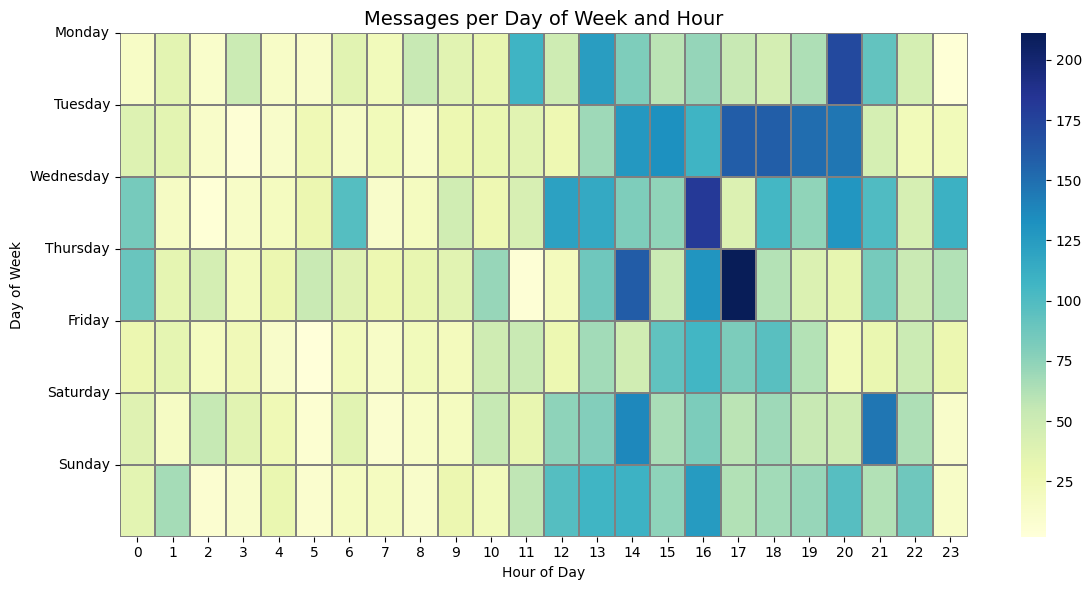

In [13]:
# Make a copy of the threads and answers together
all_posts_df = pd.concat([
    threads_df[['posted_at']],
    answers_df[['posted_at']]
], ignore_index=True)

# Extract hour and weekday
all_posts_df['hour'] = all_posts_df['posted_at'].dt.hour
all_posts_df['weekday'] = all_posts_df['posted_at'].dt.weekday  # Monday=0

# Count messages per (weekday, hour)
heatmap_data = all_posts_df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.3, linecolor='gray')
plt.title("Messages per Day of Week and Hour", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.yticks(ticks=range(7), labels=[calendar.day_name[d] for d in range(7)], rotation=0)
plt.tight_layout()
plt.show()

### Compute and plot response times

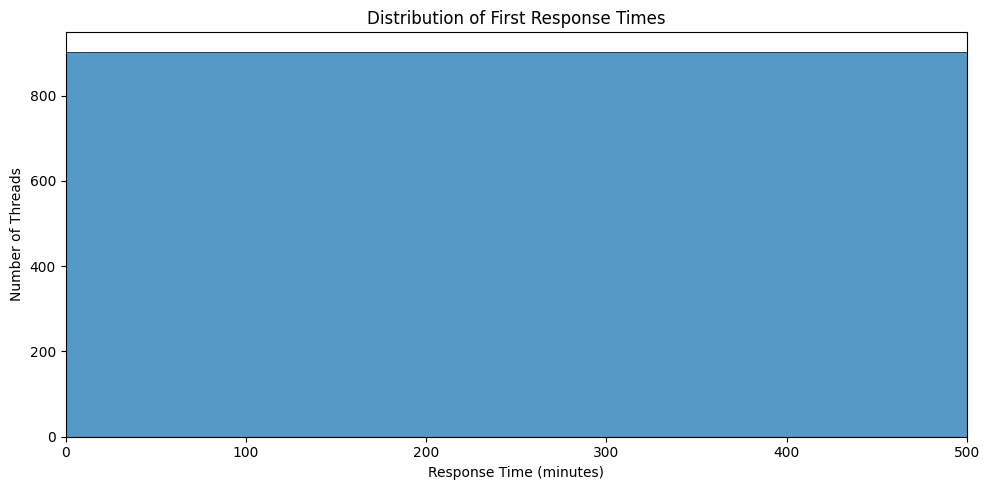

In [14]:
# Merge threads and answers to align answers with their thread
merged_df = pd.merge(
    answers_df,
    threads_df[['category_id', 'thread_id', 'posted_at']],
    on=['category_id', 'thread_id'],
    suffixes=('_answer', '_question')
)

# Compute response time in minutes
merged_df['response_time_minutes'] = (
    merged_df['posted_at_answer'] - merged_df['posted_at_question']
).dt.total_seconds() / 60

# Keep only the first answer per thread
first_responses = merged_df.sort_values('posted_at_answer') \
    .groupby(['category_id', 'thread_id']) \
    .first().reset_index()

# Plot histogram (clip long delays to improve readability)
plt.figure(figsize=(10, 5))
sns.histplot(first_responses['response_time_minutes'], bins=100, kde=False)
plt.xlim(0, 500)  # You can adjust this to show tail separately
plt.xlabel("Response Time (minutes)")
plt.ylabel("Number of Threads")
plt.title("Distribution of First Response Times")
plt.tight_layout()

# Save figure
plt.savefig("../reports/response_time_histogram.png", dpi=300)
plt.show()

In [15]:
first_responses['response_time_minutes'].describe()

count       951.000000
mean       1074.200911
std       10457.872221
min           0.000000
25%           0.716667
50%          10.450000
75%         116.766667
max      213176.166667
Name: response_time_minutes, dtype: float64

In [16]:
first_responses['response_time_minutes'].value_counts().head(10)

response_time_minutes
0.016667    66
0.033333    32
0.000000    13
0.550000     8
0.883333     8
0.466667     8
1.416667     7
0.633333     7
0.650000     7
0.716667     7
Name: count, dtype: int64

### Zoom in on realistic response times (0–60 mins)

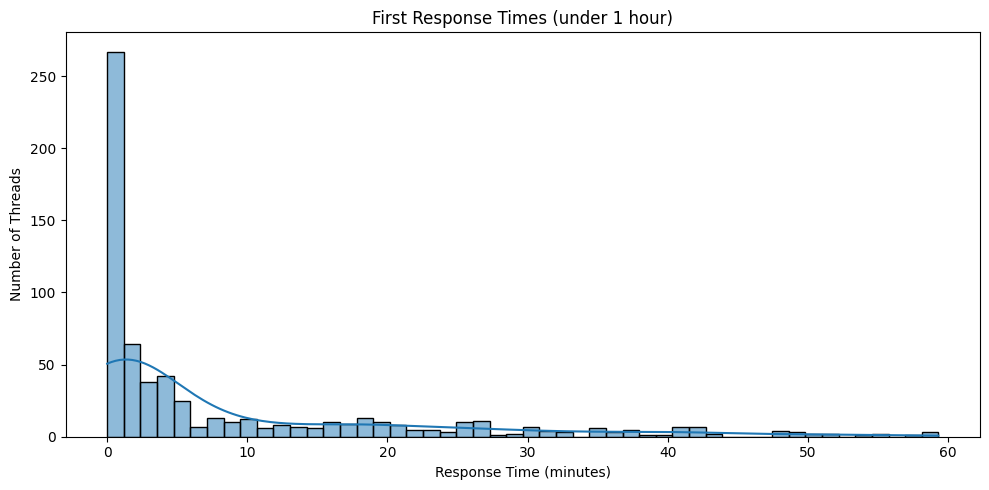

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(first_responses[first_responses['response_time_minutes'] < 60]['response_time_minutes'],
             bins=50, kde=True)
plt.xlabel("Response Time (minutes)")
plt.ylabel("Number of Threads")
plt.title("First Response Times (under 1 hour)")
plt.tight_layout()
plt.savefig("../reports/response_time_histogram_zoomed.png", dpi=300)
plt.show()

### Plot messages per day (line chart)

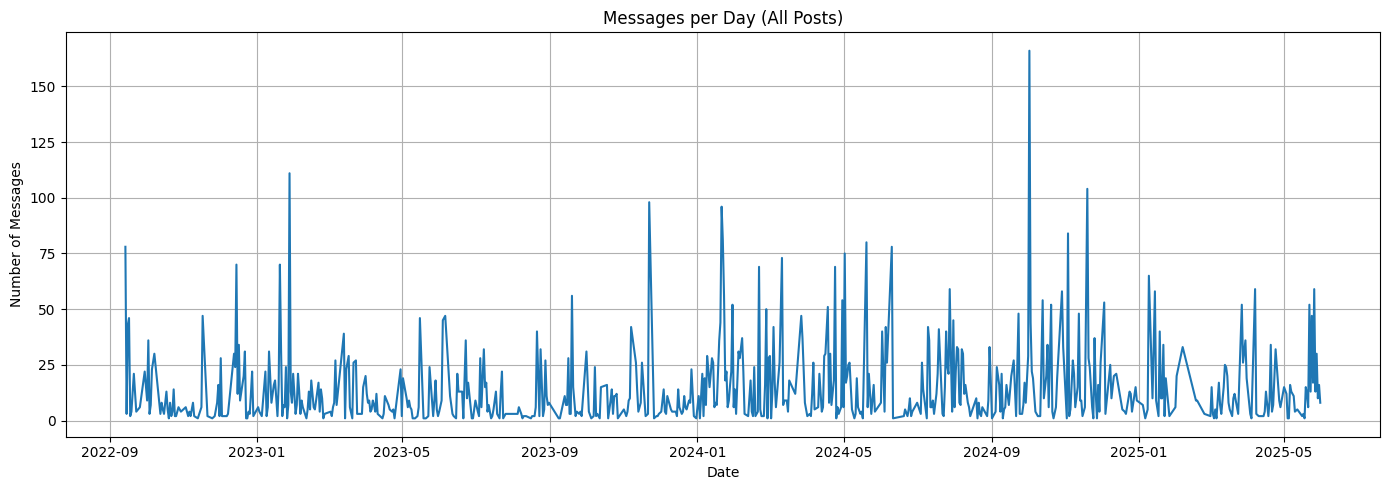

In [12]:
# Combine all timestamps
all_posts_df = pd.concat([
    threads_df[['posted_at']],
    answers_df[['posted_at']]
], ignore_index=True)

# Extract date only
all_posts_df['date'] = all_posts_df['posted_at'].dt.date

# Count messages per day
daily_counts = all_posts_df.groupby('date').size()

# Plot
plt.figure(figsize=(14, 5))
daily_counts.plot(kind='line')
plt.title("Messages per Day (All Posts)")
plt.xlabel("Date")
plt.ylabel("Number of Messages")
plt.grid(True)
plt.tight_layout()

# Save figure
plt.savefig("../reports/messages_per_day_linechart.png", dpi=300)
plt.show()

### Plot length distributions

KeyError: 'question_length'

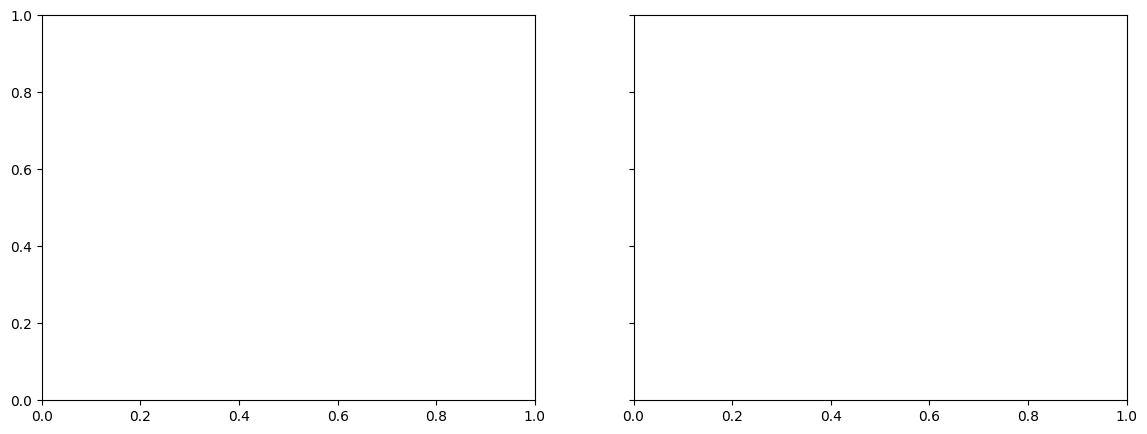

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Question length
sns.histplot(threads_df['question_length'], bins=50, color='skyblue', kde=True, ax=axes[0])
axes[0].set_title("Question Length Distribution")
axes[0].set_xlabel("Length (characters)")
axes[0].set_ylabel("Number of Questions")

# Answer length
sns.histplot(answers_df['answer_length'], bins=50, color='salmon', kde=True, ax=axes[1])
axes[1].set_title("Answer Length Distribution")
axes[1].set_xlabel("Length (characters)")

plt.tight_layout()
plt.savefig("../reports/message_length_distribution_split.png", dpi=300)
plt.show()

### Generate Word Cloud from Questions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


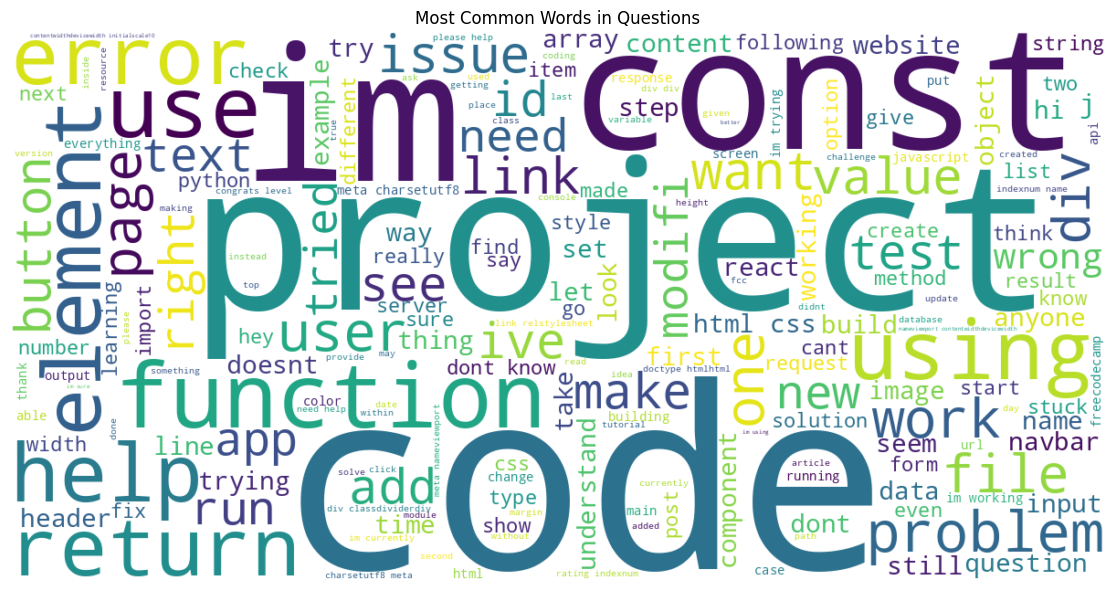

In [18]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords if needed
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Combine all questions
all_question_text = " ".join(threads_df['question'].dropna().astype(str).tolist())

# Basic cleaning
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

clean_text = preprocess(all_question_text)

# Generate word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white', max_words=200).generate(clean_text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Questions")
plt.tight_layout()
plt.savefig("../reports/question_wordcloud.png", dpi=300)
plt.show()

### Word Cloud from Answers

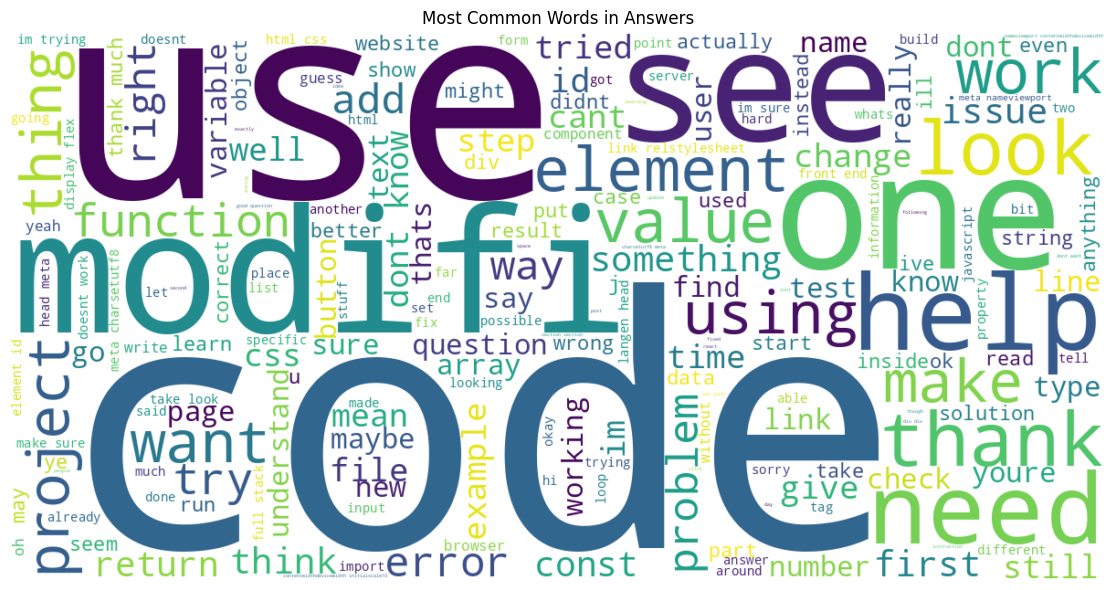

In [22]:
# Combine all answers
all_answer_text = " ".join(answers_df['answer_text'].dropna().astype(str).tolist())

# Reuse same preprocessing function
clean_answer_text = preprocess(all_answer_text)

# Generate word cloud
answer_wordcloud = WordCloud(
    width=1200, height=600, background_color='white', max_words=200
).generate(clean_answer_text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(answer_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Answers")
plt.tight_layout()
plt.savefig("../reports/answer_wordcloud.png", dpi=300)
plt.show()

### Plot distribution of total posts per user

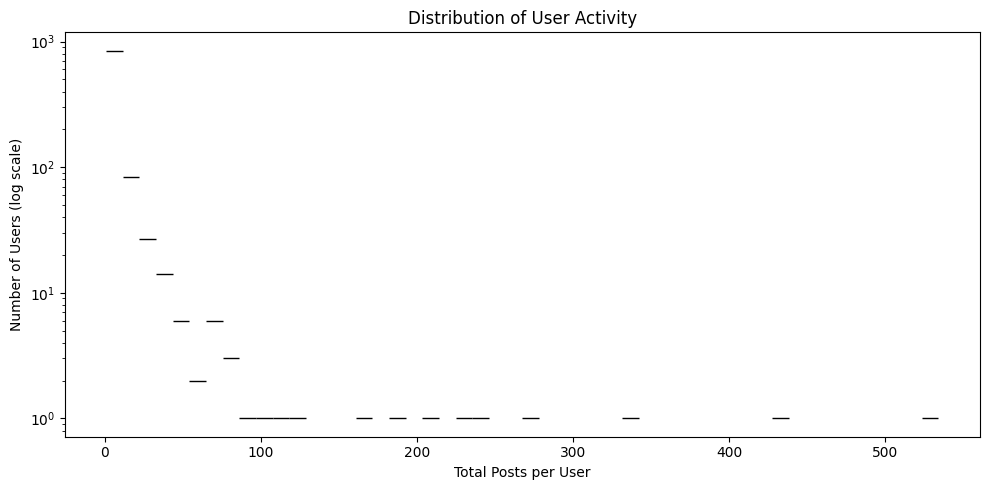

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(user_stats_df['total_posts'], bins=50, log_scale=(False, True))
plt.xlabel("Total Posts per User")
plt.ylabel("Number of Users (log scale)")
plt.title("Distribution of User Activity")
plt.tight_layout()
plt.savefig("../reports/user_activity_distribution.png", dpi=300)
plt.show()

### Binned User Activity Bar Chart

C:\Users\MSI\AppData\Local\Temp\ipykernel_14240\3475955284.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=activity_counts.index, y=activity_counts.values, palette='viridis')


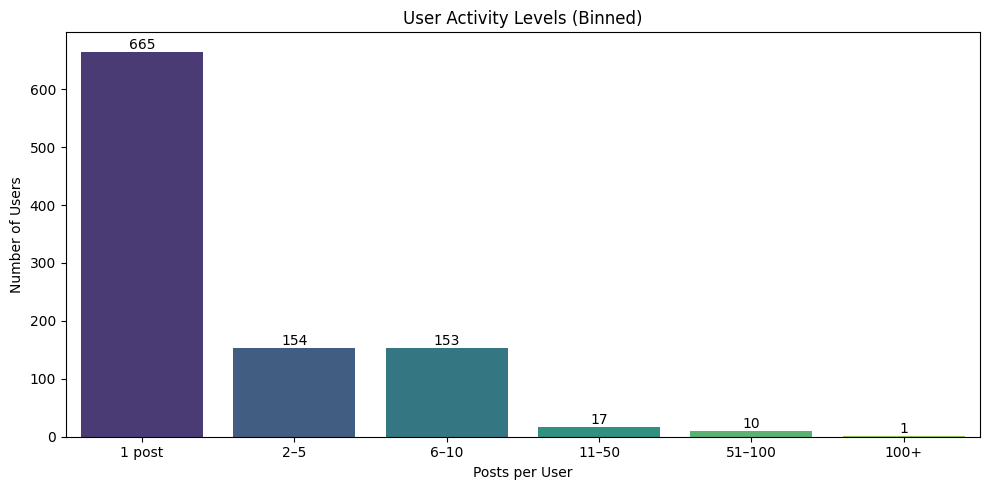

In [27]:
# Bin users by total posts
bins = [1, 5, 10, 50, 100, 500, float('inf')]
labels = ['1 post', '2–5', '6–10', '11–50', '51–100', '100+']
user_stats_df['activity_bin'] = pd.cut(user_stats_df['total_posts'], bins=bins, labels=labels, right=False)

# Count users per bin
activity_counts = user_stats_df['activity_bin'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=activity_counts.index, y=activity_counts.values, palette='viridis')
plt.title("User Activity Levels (Binned)")
plt.xlabel("Posts per User")
plt.ylabel("Number of Users")

# Add value labels on bars
for i, v in enumerate(activity_counts.values):
    ax.text(i, v + 5, str(v), color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig("../reports/user_activity_binned_labeled.png", dpi=300)
plt.show()

### Compare answer counts by is_bot

C:\Users\MSI\AppData\Local\Temp\ipykernel_14240\2779831437.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


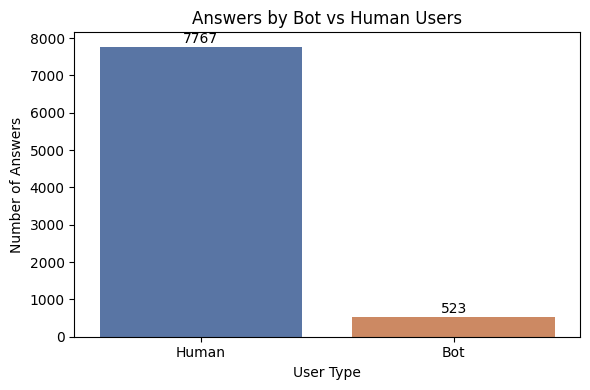

In [29]:
# Count answers by bot/human
bot_answer_counts = answers_df.merge(
    user_stats_df[['author', 'is_bot']],
    on='author', how='left'
)['is_bot'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    x=bot_answer_counts.index.map({False: "Human", True: "Bot"}),
    y=bot_answer_counts.values,
    palette="deep"
)
plt.title("Answers by Bot vs Human Users")
plt.ylabel("Number of Answers")
plt.xlabel("User Type")

# Add count labels
for i, v in enumerate(bot_answer_counts.values):
    ax.text(i, v + 100, str(v), ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.savefig("../reports/answer_count_by_user_type_labeled.png", dpi=300)
plt.show()

### Count answers per thread

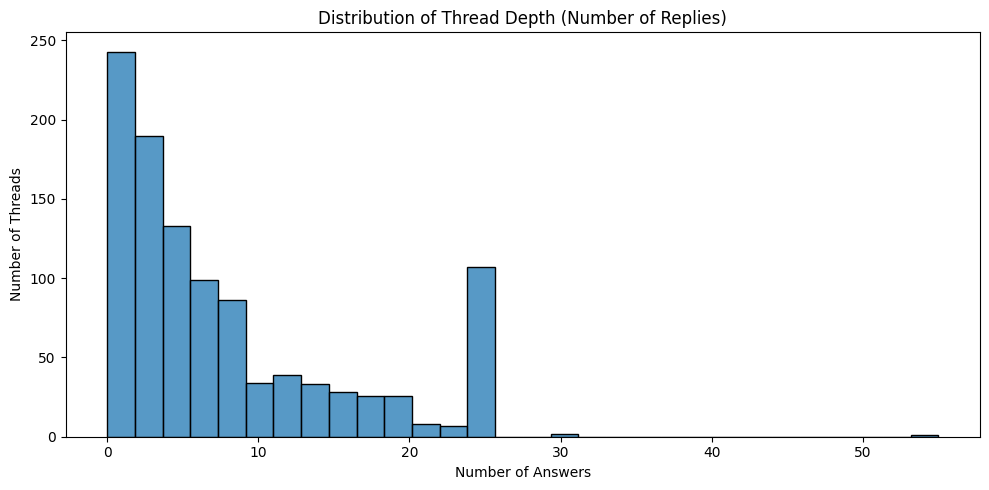

In [30]:
# Count number of answers per thread
thread_reply_counts = answers_df.groupby(['category_id', 'thread_id']).size().reset_index(name='answer_count')

# Merge with threads to get titles (optional)
thread_depth_df = threads_df.merge(thread_reply_counts, on=['category_id', 'thread_id'], how='left')
thread_depth_df['answer_count'] = thread_depth_df['answer_count'].fillna(0)

# Plot distribution
plt.figure(figsize=(10, 5))
sns.histplot(thread_depth_df['answer_count'], bins=30)
plt.title("Distribution of Thread Depth (Number of Replies)")
plt.xlabel("Number of Answers")
plt.ylabel("Number of Threads")
plt.tight_layout()
plt.savefig("../reports/thread_depth_distribution.png", dpi=300)
plt.show()

### Top 20 Most Replied-to Threads

In [31]:
# Already computed in thread_depth_df earlier
top_threads = thread_depth_df.sort_values(by='answer_count', ascending=False).head(20)

# Display relevant columns
top_threads_display = top_threads[['thread_id', 'title', 'answer_count']]

# Optionally: save to CSV for the report
top_threads_display.to_csv("../reports/top_20_threads_by_replies.csv", index=False)

# Show in notebook
top_threads_display

,thread_id,title,answer_count
1033,490,Doubts,55.0
561,30,react calculator,31.0
4,9,What's wrong with this code?,30.0
1043,363,Looking for a learning partner,25.0
437,356,TailwindCss help,25.0
998,235,Scientific Computing with Python (Beta),25.0
1061,528,Hello~!,25.0
41,105,Cat Photo App- Step 40,25.0
451,400,Build a Technical Documentation Page,25.0
366,177,Sometimes this works sometimes it doesn't???,25.0


### Average replies by hour of day

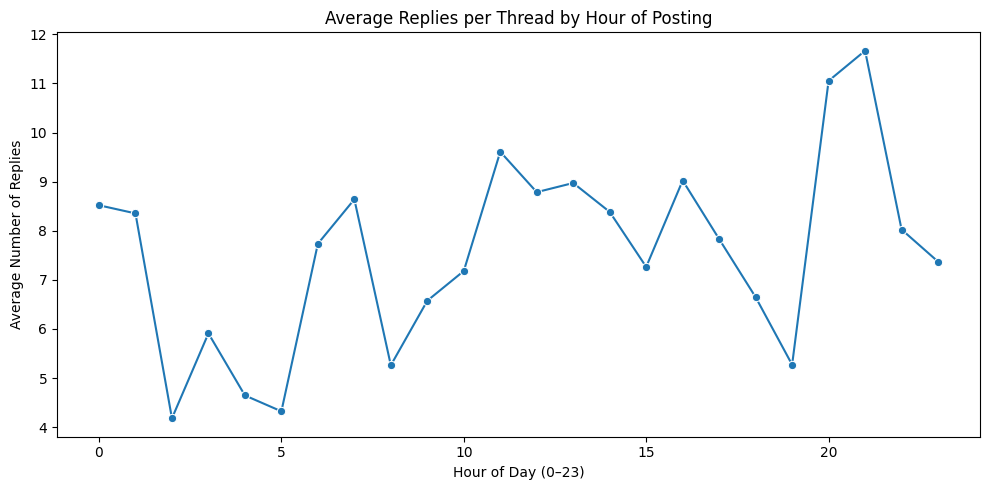

In [32]:
# Extract hour from post time
threads_df['hour'] = threads_df['posted_at'].dt.hour

# Merge with reply counts
threads_with_replies = threads_df.merge(
    thread_depth_df[['thread_id', 'category_id', 'answer_count']],
    on=['thread_id', 'category_id'],
    how='left'
)

# Group by hour
hourly_replies = threads_with_replies.groupby('hour')['answer_count'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_replies, x='hour', y='answer_count', marker='o')
plt.title("Average Replies per Thread by Hour of Posting")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average Number of Replies")
plt.tight_layout()
plt.savefig("../reports/replies_by_hour.png", dpi=300)
plt.show()

### Messages and Replies by Category

C:\Users\MSI\AppData\Local\Temp\ipykernel_14240\3854001145.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


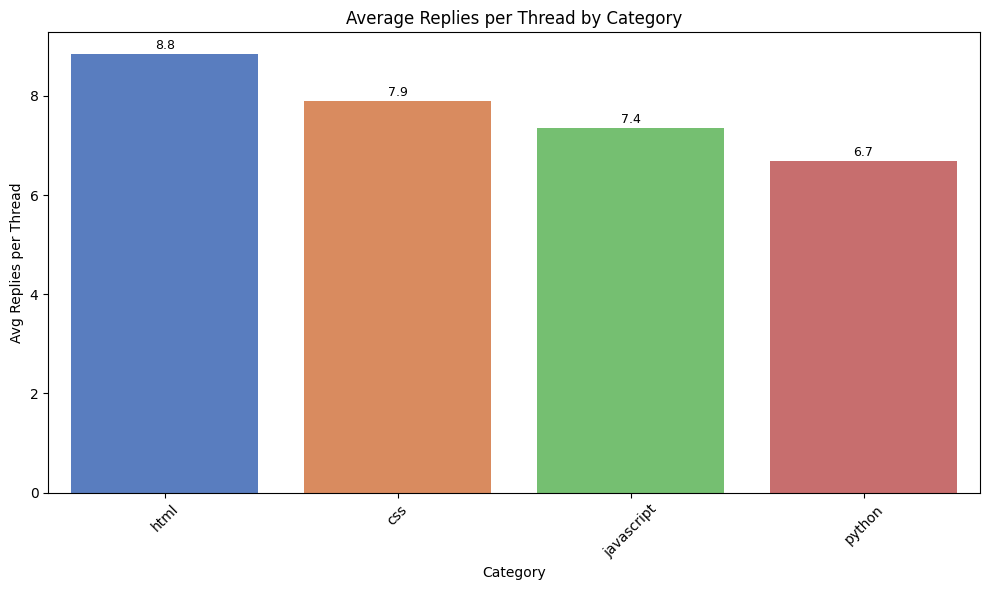

In [36]:
# Same as before: calculate per-category reply stats
thread_counts = threads_df['category_id'].value_counts().rename('thread_count')
answer_counts = answers_df['category_id'].value_counts().rename('answer_count')

category_summary = pd.DataFrame({'category_id': thread_counts.index})
category_summary = category_summary.merge(categories_df, on='category_id', how='left')
category_summary = category_summary.merge(thread_counts, on='category_id')
category_summary = category_summary.merge(answer_counts, on='category_id')
category_summary['avg_answers_per_thread'] = category_summary['answer_count'] / category_summary['thread_count']

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=category_summary.sort_values('avg_answers_per_thread', ascending=False),
    x='name', y='avg_answers_per_thread', palette='muted'
)

# Add labels
for i, v in enumerate(category_summary.sort_values('avg_answers_per_thread', ascending=False)['avg_answers_per_thread']):
    ax.text(i, v + 0.1, f"{v:.1f}", ha='center', fontsize=9)

plt.title("Average Replies per Thread by Category")
plt.xlabel("Category")
plt.ylabel("Avg Replies per Thread")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../reports/avg_replies_by_category_labeled.png", dpi=300)
plt.show()